# BASICS 03 - HOTS with online classification

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os
from timesurface import timesurface
from network import network
from utils import get_loader

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.15
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [20]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)
loader = get_loader(trainset, shuffle=True)
print(f'number of samples in the training set: {len(loader)}')

number of samples in the training set: 48


## Initialization of the network

In [22]:
name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [4, 8]
tauz = [1e3, 2e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

## Unsupervised clustering

In [23]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold, record = True)

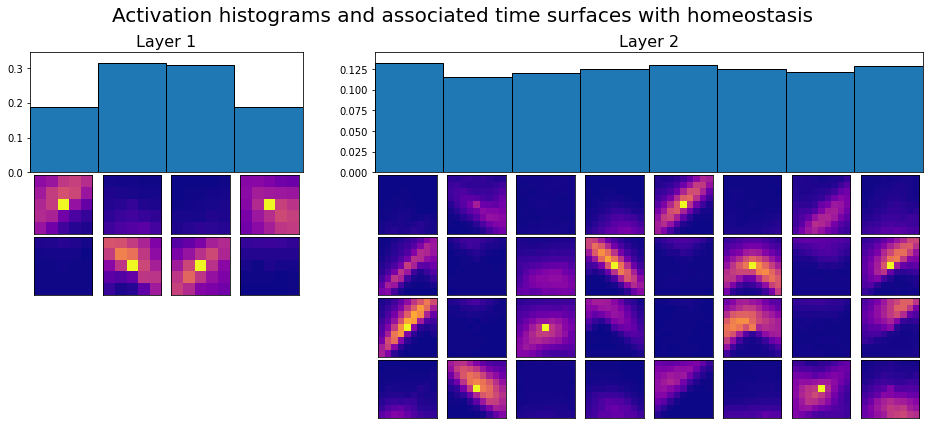

In [13]:
hots.plotlayers();

In [14]:
hots.plotlearning();

FileNotFoundError: [Errno 2] No such file or directory: '../Records/networks/2022-04-22_poker_homeohots_True_[4, 8]_[1000.0, 2000.0]_[2, 4]_recorded_parameters.pkl'

## Coding of the training set

In [24]:
loader = get_loader(trainset)
hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)

this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8]_[1000.0, 2000.0]_[2, 4]_48_(None, None)/


## Coding of the testing set

In [16]:
loader = get_loader(test, kfold = None, shuffle=True)
hots.coding(loader, dataset.ordering, dataset.classes, filtering_threshold, training=trainset)

  0%|                                                                                                                                                                                                                                     | 2/10000 [00:04<6:17:32,  2.27s/it]


KeyboardInterrupt: 

## Classification with histogram (post-hoc)

In [ ]:
from utils import make_histogram_classification, HOTS_Dataset

jitter = (None, None)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

testset = HOTS_Dataset(test_path, dataset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
trainset = HOTS_Dataset(train_path, dataset.sensor_size, transform=tonic.transforms.NumpyAsType(int))

In [ ]:
score = make_histogram_classification(trainset, testset, N_neuronz[-1])
print(f' Accuracy: {score*100}%')